# Improving Mock Data Errors with Emperical Results

The data in this notebook is generated in the same way as in `Bootstrap-Own-Data.ipynb`. However, instead of bootstrapping to get error estimates, each sample will be given it's own error estimate based on the mass-to-distance ratio, $\frac{m_1}{d_L}$. The exact formula comes from a logramthic least-squares fit from the LIGO O3a and b datasets, which can be found [here](https://github.com/ctmurphey/Combined-O3ab). These functions are already stored in `MCMC_functions.py`.

In [1]:
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import arviz as az
from astropy.cosmology import Planck18
from tqdm import tqdm
import seaborn as sns
from MCMC_functions import *
from astropy.cosmology import units as cu

sns.set_context('notebook')
sns.set_palette('colorblind')

import matplotlib
matplotlib.rcParams['font.family'] = 'serif' # so these plots can go into thesis


%matplotlib inline

21.773540755793668 2.359148346083856 73.13947975749589
(10000,)


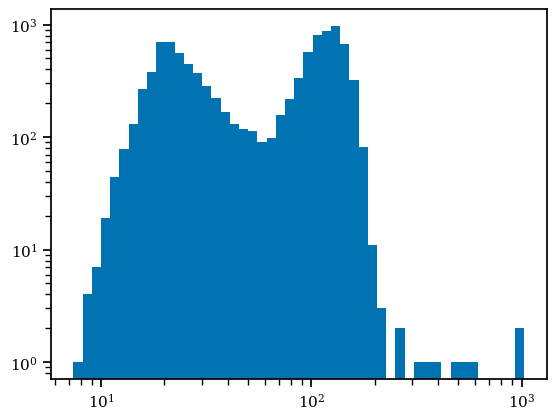

In [2]:
ms = generate_masses(f=0.5)
dLs = generate_dLs()
zs = dLs_to_zs(dLs)

m_det = ms*(1+zs)
print(np.mean(ms), np.mean(zs), np.mean(m_det))
print(m_det.shape)
plt.hist(m_det, bins=np.logspace(np.log10(min(m_det)), np.log10(max(m_det)), 50))
plt.xscale('log')
plt.yscale('log')

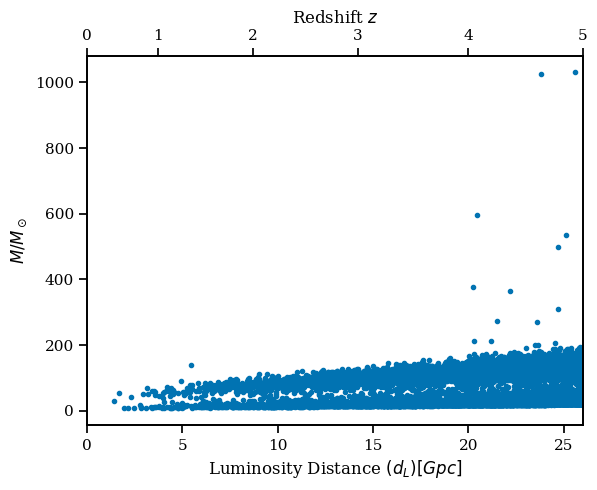

In [3]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.scatter(dLs/1000, m_det, marker='.')
ax1.set_xlabel(r"Luminosity Distance $(d_L) [Gpc]$")
ax1.set_ylabel(r"$M/M_\odot$")

tick_labels = np.linspace(0, 5, 6, dtype=int)
new_tick_locations = Planck18.luminosity_distance(tick_labels)
ax2.set_xlim(0, 5)
ax1.set_xlim(0, max(dLs/1000))
ax2.set_xticks(new_tick_locations.value)
ax2.set_xticklabels(tick_labels)
ax2.set_xlabel(r"Redshift $z$")
plt.show()

In [4]:
m_dls = m_det/dLs
sigma_dls = sigma_dL(m_dls)
sigma_ms  = sigma_m(m_dls)

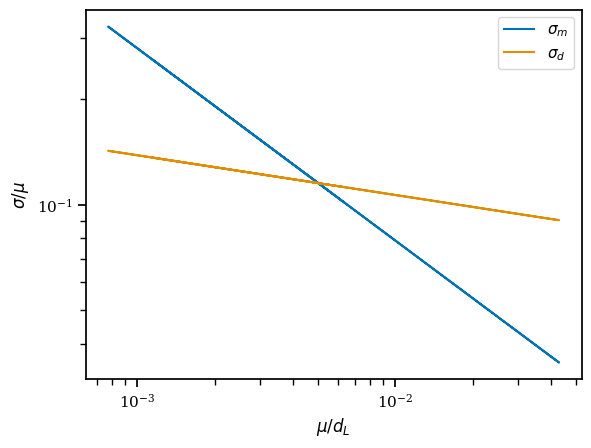

In [5]:
plt.loglog(m_dls, sigma_ms, label=r"$\sigma_m$")
plt.loglog(m_dls, sigma_dls, label=r"$\sigma_d$")
plt.xlabel(r"$\mu/d_L$")
plt.ylabel(r"$\sigma/\mu$")
plt.legend()

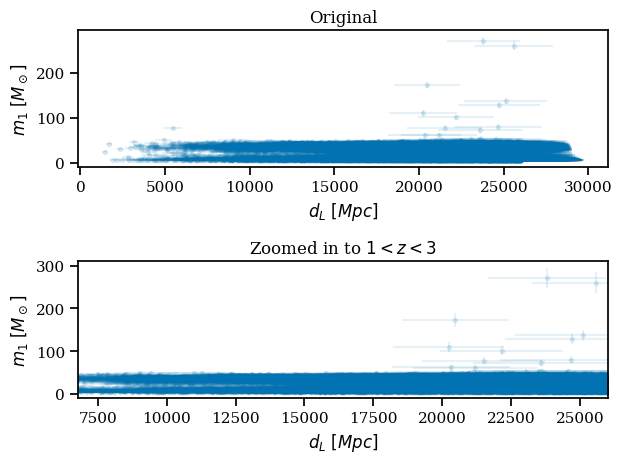

In [6]:
fig, axs = plt.subplots(2, 1)

axs[0].errorbar(dLs, ms, xerr=sigma_dls*dLs, yerr=sigma_ms*ms, fmt='.', alpha=0.1)
axs[0].set_xlabel(r"$d_L\ [Mpc]$")
axs[0].set_ylabel(r"$m_1\ [M_\odot]$")
axs[0].set_title("Original")

axs[1].errorbar(dLs, ms, xerr=sigma_dls*dLs, yerr=sigma_dls*ms, fmt='.', alpha=0.1)
axs[1].set_xlabel(r"$d_L\ [Mpc]$")
axs[1].set_ylabel(r"$m_1\ [M_\odot]$")
axs[1].set_xlim(Planck18.luminosity_distance(1).value, Planck18.luminosity_distance(3).value)
axs[1].set_title(r"Zoomed in to $1<z<3$")
fig.tight_layout()

100%|██████████| 8/8 [00:56<00:00,  7.08s/it]


Text(0, 0.5, '$m_\\mathrm{peak} / M_\\odot$')

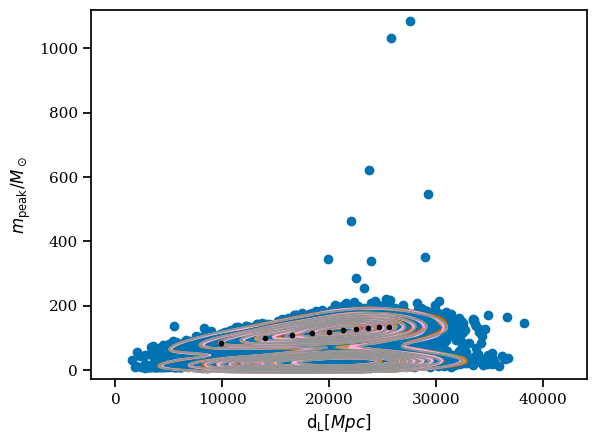

In [7]:
n_events = len(m_det)
n_dLs=10
n_mc = 8
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(dLs)
dL_max = max(dLs)

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
dL_cent = np.quantile(dLs, np.linspace(0.05, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

for run in tqdm(range(n_mc)):

    m_det_mc = np.random.lognormal(mean=np.log(m_det), sigma=sigma_ms)
    # print(m_det_mc[0])
    d_Ls_mc = np.random.lognormal(mean=np.log(dLs), sigma=sigma_dls)


    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        # redshift_min = cosmo.z_at_value(Planck18.luminosity_distance)
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:])
    
    kplot = sns.kdeplot(x=d_Ls_mc, y=m_det_mc)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(d_Ls_mc, m_det_mc)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
# plt.xlim(Planck18.luminosity_distance(0).value, Planck18.luminosity_distance(4).value)
# plt.ylim(30, 50)

<ErrorbarContainer object of 3 artists>

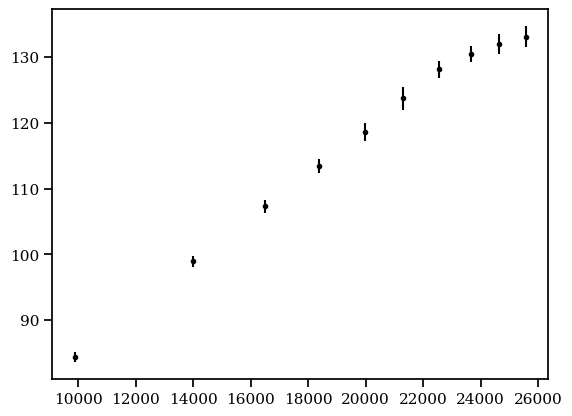

In [8]:
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.


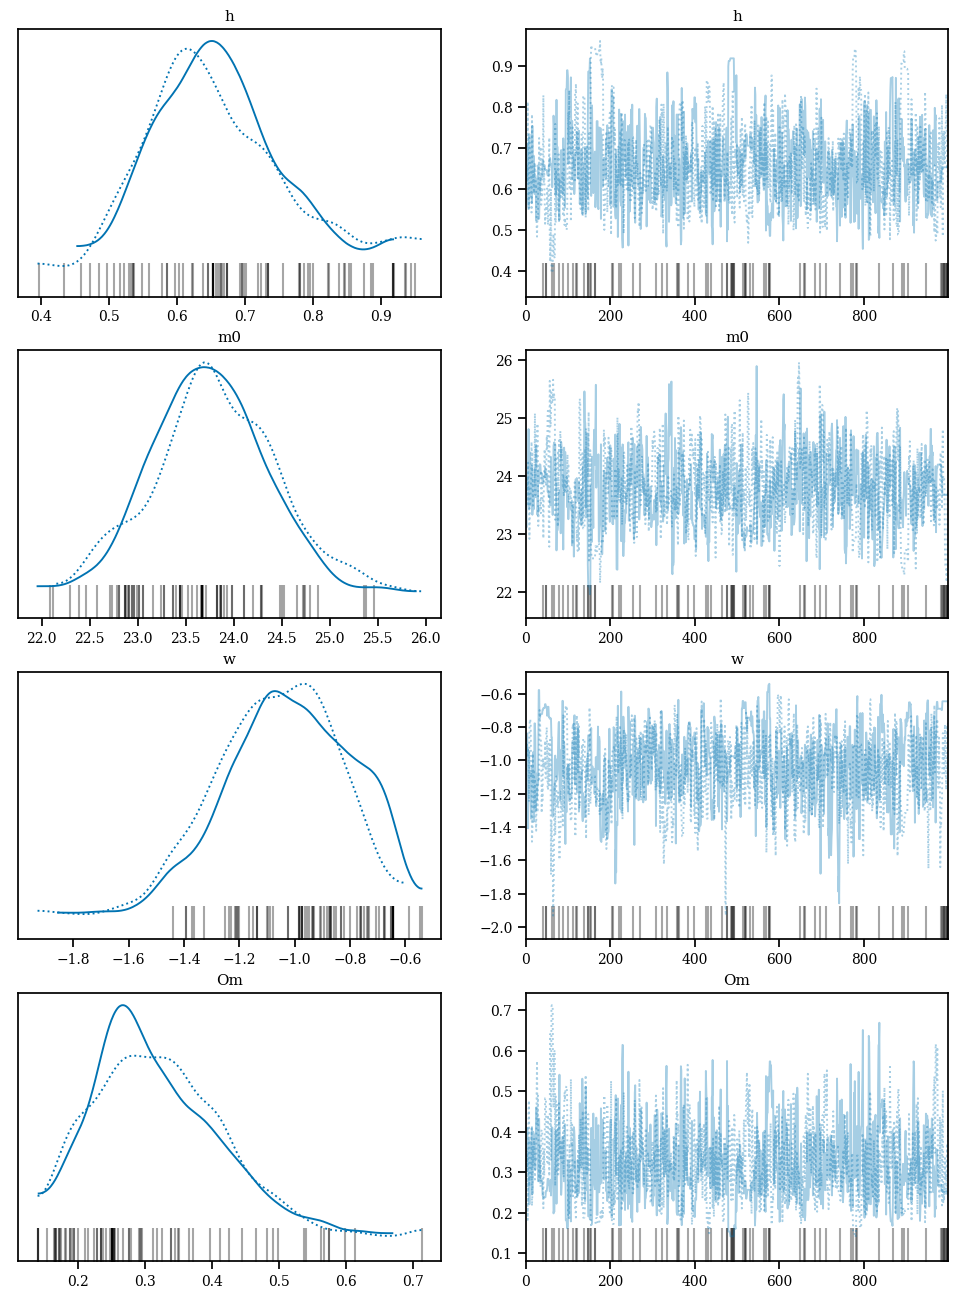

In [9]:
mu_m = np.mean(mpeak_samples, axis=0)
sigmam = np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_m, sigma_ms_obs=sigmam, dls=dL_cent, zmin=1, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'], figsize=(12, 16))
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

<ErrorbarContainer object of 3 artists>

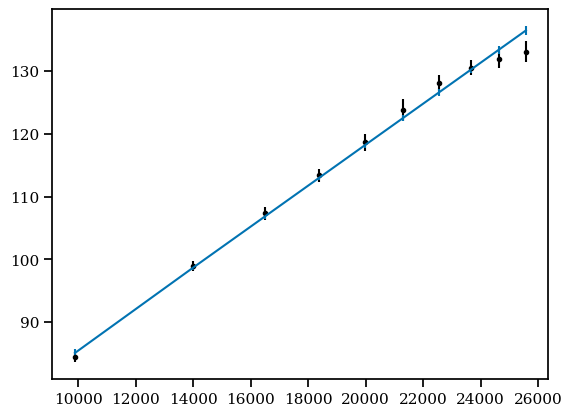

In [10]:
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.errorbar(dL_cent, trace.posterior['m_peak'].mean(dim=['chain', 'draw']), yerr=trace.posterior['m_peak'].std(dim=['chain', 'draw']))

array([[<AxesSubplot:ylabel='Om'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='h', ylabel='w'>, <AxesSubplot:xlabel='Om'>]],
      dtype=object)

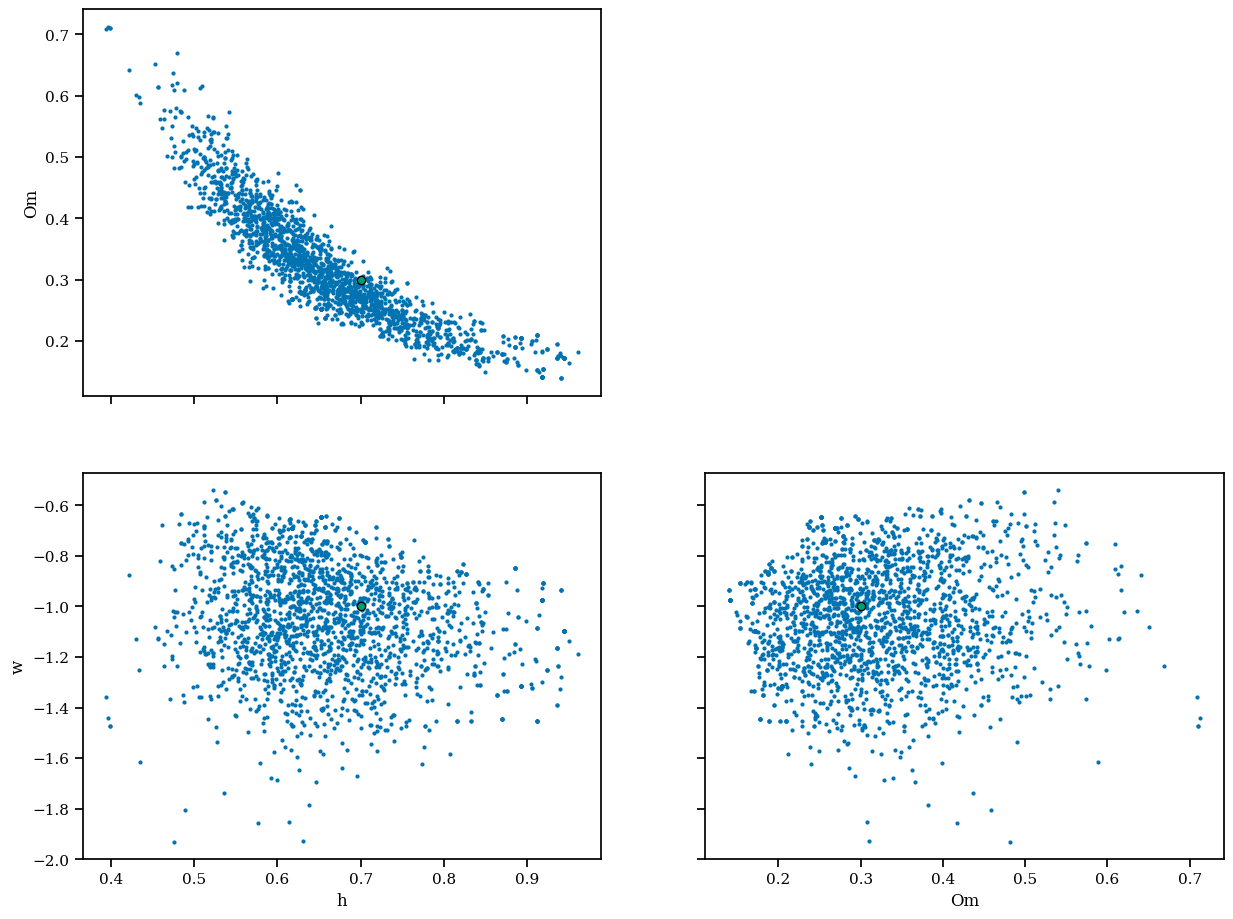

In [11]:
az.plot_pair(trace, var_names=['h', 'Om', 'w'], reference_values={'h': 0.7, 'Om':0.3, 'w':-1})

## Drop redshift down to $z=0$ using same method as in `Bootstrap-Own-Data.ipynb`


100%|██████████| 8/8 [00:57<00:00,  7.14s/it]


(-28.946566634750532, 250.0)

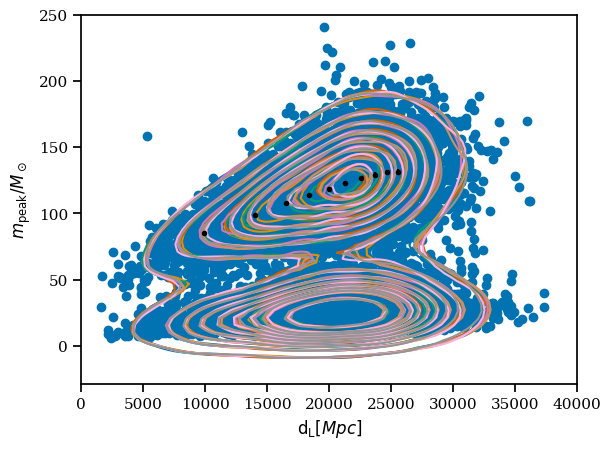

In [17]:
n_events = len(m_det)
n_dLs=10
n_mc = 8
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(dLs)
dL_max = max(dLs)

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
dL_cent = np.quantile(dLs, np.linspace(0.05, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

for run in tqdm(range(n_mc)):

    m_det_mc = np.random.lognormal(mean=np.log(m_det), sigma=sigma_ms)
    # print(m_det_mc[0])
    d_Ls_mc = np.random.lognormal(mean=np.log(dLs), sigma=sigma_dls)


    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        redshifted_min = 25*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent[i]*u.Mpc))
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:], mmin=redshifted_min)
    
    kplot = sns.kdeplot(x=d_Ls_mc, y=m_det_mc)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(d_Ls_mc, m_det_mc)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.xlim(0,40000)
plt.ylim(top=250)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.


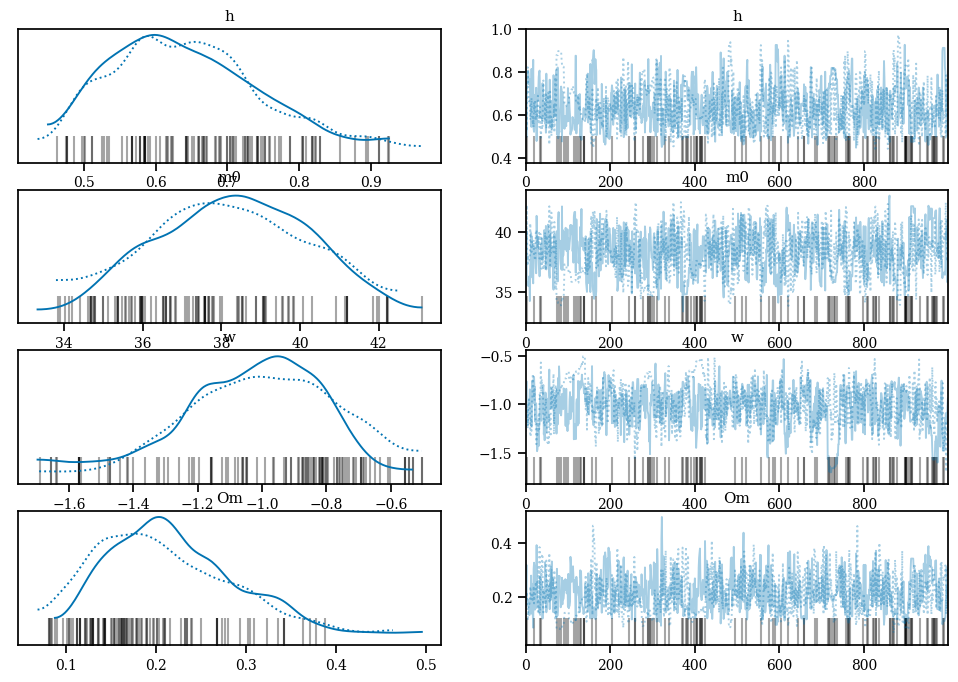

In [18]:
with make_model(ms_obs=mu_m, sigma_ms_obs=sigmam, dls=dL_cent, zmin=0, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

<ErrorbarContainer object of 3 artists>

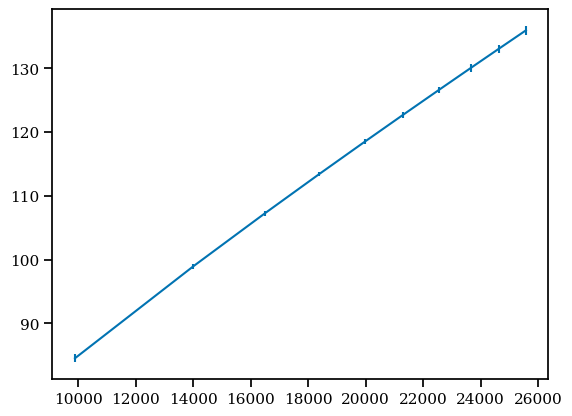

In [16]:
plt.errorbar(dL_cent, trace.posterior['m_peak'].mean(dim=['chain', 'draw']), yerr=trace.posterior['m_peak'].std(dim=['chain', 'draw']))